# Trace Analysis Examples

## Kernel Functions Profiling
Details on functions profiling are given in **Plot Functions Profiling Data** below.

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2016-12-12 12:54:48,228 INFO    : root         : Using LISA logging configuration:
2016-12-12 12:54:48,229 INFO    : root         :   /home/vagrant/lisa/logging.conf


#### Import required modules

In [2]:
# Generate plots inline
%matplotlib inline

import json
import os

# Support to access the remote target
import devlib
from env import TestEnv
from executor import Executor

# RTApp configurator for generation of PERIODIC tasks
from wlgen import RTA, Ramp

# Support for trace events analysis
from trace import Trace

## Target Configuration
The target configuration is used to describe and configure your test environment.
You can find more details in **examples/utils/testenv_example.ipynb**.

In [3]:
# Setup target configuration
my_conf = {

    # Target platform and board
    "platform"    : 'linux',
    "board"       : 'juno',
    "host"        : '192.168.0.1',
    "password"    : 'juno',

    # Folder where all the results will be collected
    "results_dir" : "TraceAnalysis_FunctionsProfiling",

    # Define devlib modules to load
    "modules": ['cpufreq'],
    "exclude_modules" : [ 'hwmon' ],

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
        "functions" : [
            "pick_next_task_fair",
            "select_task_rq_fair",
            "enqueue_task_fair",
            "update_curr_fair",
            "dequeue_task_fair",
        ],
        
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'rt-app' ],
    
    # Comment this line to calibrate RTApp in your own platform
    # "rtapp-calib" :  {"0": 360, "1": 142, "2": 138, "3": 352, "4": 352, "5": 353},
}

In [4]:
# Initialize a test environment using:
te = TestEnv(my_conf, wipe=False, force_new=True)
target = te.target

2016-12-07 13:11:43,327 INFO    : TestEnv      : Using base path: /home/vagrant/lisa
2016-12-07 13:11:43,328 INFO    : TestEnv      : Loading custom (inline) target configuration
2016-12-07 13:11:43,329 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpufreq']
2016-12-07 13:11:43,329 INFO    : TestEnv      : Connecting linux target:
2016-12-07 13:11:43,329 INFO    : TestEnv      :   username : root
2016-12-07 13:11:43,330 INFO    : TestEnv      :       host : 192.168.0.1
2016-12-07 13:11:43,330 INFO    : TestEnv      :   password : juno
2016-12-07 13:11:43,331 INFO    : TestEnv      : Connection settings:
2016-12-07 13:11:43,331 INFO    : TestEnv      :    {'username': 'root', 'host': '192.168.0.1', 'password': 'juno'}
2016-12-07 13:11:50,441 INFO    : TestEnv      : Initializing target workdir:
2016-12-07 13:11:50,442 INFO    : TestEnv      :    /root/devlib-target
2016-12-07 13:12:11,403 INFO    : TestEnv      : Topology:
2016-12-07 13:12:11,404 INFO    : TestEnv      :    [

## Workload Execution and Functions Profiling Data Collection

Detailed information on RTApp can be found in **examples/wlgen/rtapp_example.ipynb**.

In [5]:
def experiment(te):

    # Create and RTApp RAMP task
    rtapp = RTA(te.target, 'ramp', calibration=te.calibration())
    rtapp.conf(kind='profile',
               params={
                    'ramp' : Ramp(
                        start_pct =  60,
                        end_pct   =  20,
                        delta_pct =   5,
                        time_s    =   0.5).get()
              })

    # FTrace the execution of this workload
    te.ftrace.start()
    rtapp.run(out_dir=te.res_dir)
    te.ftrace.stop()

    # Collect and keep track of the trace
    trace_file = os.path.join(te.res_dir, 'trace.dat')
    te.ftrace.get_trace(trace_file)
    
    # Collect and keep track of the Kernel Functions performance data
    stats_file = os.path.join(te.res_dir, 'trace.stats')
    te.ftrace.get_stats(stats_file)

    # Dump platform descriptor
    te.platform_dump(te.res_dir)

In [6]:
experiment(te)

2016-12-07 13:12:22,250 INFO    : Workload     : Setup new workload ramp
2016-12-07 13:12:22,254 INFO    : Workload     : Workload duration defined by longest task
2016-12-07 13:12:22,255 INFO    : Workload     : Default policy: SCHED_OTHER
2016-12-07 13:12:22,256 INFO    : Workload     : ------------------------
2016-12-07 13:12:22,256 INFO    : Workload     : task [ramp], sched: using default policy
2016-12-07 13:12:22,257 INFO    : Workload     :  | calibration CPU: 1
2016-12-07 13:12:22,257 INFO    : Workload     :  | loops count: 1
2016-12-07 13:12:22,258 INFO    : Workload     : + phase_000001: duration 0.500000 [s] (5 loops)
2016-12-07 13:12:22,258 INFO    : Workload     : |  period   100000 [us], duty_cycle  60 %
2016-12-07 13:12:22,259 INFO    : Workload     : |  run_time  60000 [us], sleep_time  40000 [us]
2016-12-07 13:12:22,259 INFO    : Workload     : + phase_000002: duration 0.500000 [s] (5 loops)
2016-12-07 13:12:22,260 INFO    : Workload     : |  period   100000 [us], d

## Parse Trace and Profiling Data

In [7]:
# Base folder where tests folder are located
res_dir = te.res_dir
logging.info('Content of the output folder %s', res_dir)
!tree {res_dir}

2016-12-07 13:13:03,632 INFO    : root         : Content of the output folder /home/vagrant/lisa/results/TraceAnalysis_FunctionsProfiling


/home/vagrant/lisa/results/TraceAnalysis_FunctionsProfiling
├── output.log
├── platform.json
├── ramp_00.json
├── rt-app-ramp-0.log
├── trace.dat
├── trace.raw.txt
├── trace.stats
└── trace.txt

0 directories, 8 files


In [8]:
with open(os.path.join(res_dir, 'platform.json'), 'r') as fh:
    platform = json.load(fh)
print json.dumps(platform, indent=4)
logging.info('LITTLE cluster max capacity: %d',
             platform['nrg_model']['little']['cpu']['cap_max'])

2016-12-07 13:13:07,030 INFO    : root         : LITTLE cluster max capacity: 447


{
    "nrg_model": {
        "big": {
            "cluster": {
                "nrg_max": 64
            }, 
            "cpu": {
                "cap_max": 1024, 
                "nrg_max": 616
            }
        }, 
        "little": {
            "cluster": {
                "nrg_max": 57
            }, 
            "cpu": {
                "cap_max": 447, 
                "nrg_max": 93
            }
        }
    }, 
    "clusters": {
        "big": [
            1, 
            2
        ], 
        "little": [
            0, 
            3, 
            4, 
            5
        ]
    }, 
    "cpus_count": 6, 
    "freqs": {
        "big": [
            450000, 
            625000, 
            800000, 
            950000, 
            1100000
        ], 
        "little": [
            450000, 
            575000, 
            700000, 
            775000, 
            850000
        ]
    }, 
    "topology": [
        [
            0, 
            3, 
            4, 
        

In [9]:
trace = Trace(res_dir, platform=platform)

2016-12-07 13:13:08,084 INFO    : Trace        : Parsing FTrace format...
2016-12-07 13:13:08,456 INFO    : Trace        : Trace contains only functions stats
2016-12-07 13:13:08,457 INFO    : Trace        : Collected events spans a 0.000 [s] time interval
2016-12-07 13:13:08,457 INFO    : Trace        : Set plots time range to (0.000000, 0.000000)[s]
2016-12-07 13:13:08,461 INFO    : Analysis     : Registering trace analysis modules:
2016-12-07 13:13:08,465 INFO    : Analysis     :    tasks
2016-12-07 13:13:08,468 INFO    : Analysis     :    status
2016-12-07 13:13:08,471 INFO    : Analysis     :    frequency
2016-12-07 13:13:08,473 INFO    : Analysis     :    cpus
2016-12-07 13:13:08,476 INFO    : Analysis     :    latency
2016-12-07 13:13:08,479 INFO    : Analysis     :    idle
2016-12-07 13:13:08,481 INFO    : Analysis     :    functions
2016-12-07 13:13:08,482 INFO    : Analysis     :    eas


## Report Functions Profiling Data



In [10]:
# Get the DataFrame for the specified list of kernel functions
df = trace.data_frame.functions_stats(['enqueue_task_fair', 'dequeue_task_fair'])
df

hits     avg      time     s_2
0 dequeue_task_fair  2064   9.994  20629.08  37.589
  enqueue_task_fair   701  10.302   7221.72  21.210
1 dequeue_task_fair   570   3.857   2198.90   9.192
  enqueue_task_fair   208   6.415   1334.52  15.595
2 dequeue_task_fair   148   8.643   1279.18  13.554
  enqueue_task_fair   433   3.091   1338.60   2.320
3 dequeue_task_fair   171  12.253   2095.40  33.150
  enqueue_task_fair    45   8.536    384.14  16.124
4 dequeue_task_fair   536   6.805   3647.66  28.950
  enqueue_task_fair    88   4.474    393.74   8.697
5 dequeue_task_fair   139   6.097    847.56  25.569
  enqueue_task_fair    22   6.029    132.64  15.115

In [11]:
# Get the DataFrame for the single specified kernel function
df = trace.data_frame.functions_stats('select_task_rq_fair')
df

,,hits,avg,time,s_2
0,select_task_rq_fair,714,4.641,3314.34,75.975
1,select_task_rq_fair,270,11.346,3063.56,100.978
2,select_task_rq_fair,456,4.223,1925.96,25.138
3,select_task_rq_fair,49,13.006,637.32,89.897
4,select_task_rq_fair,96,7.731,742.18,83.133
5,select_task_rq_fair,25,11.571,289.28,172.983


## Plot Functions Profiling Data

The only method of the FunctionsAnalysis class that is used for functions profiling is **plotProfilingStats**. This method is used to plot functions profiling metrics for the specified kernel functions. For each speficied metric a barplot is generated which reports the value of the metric when the kernel function has been executed on each CPU.
The default metric is **avg** if not otherwise specified. A list of kernel functions to plot can also be passed to plotProfilingStats. Otherwise, by default, all the kernel functions are plotted.

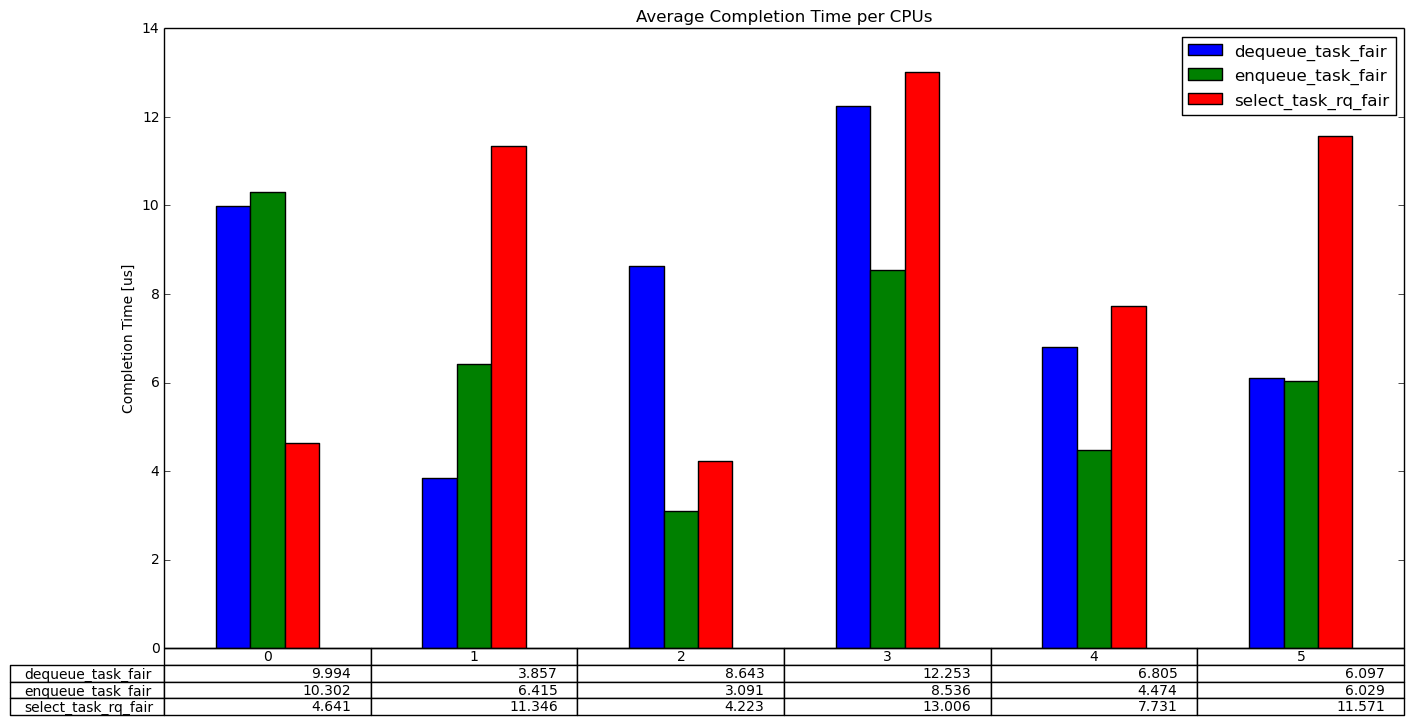

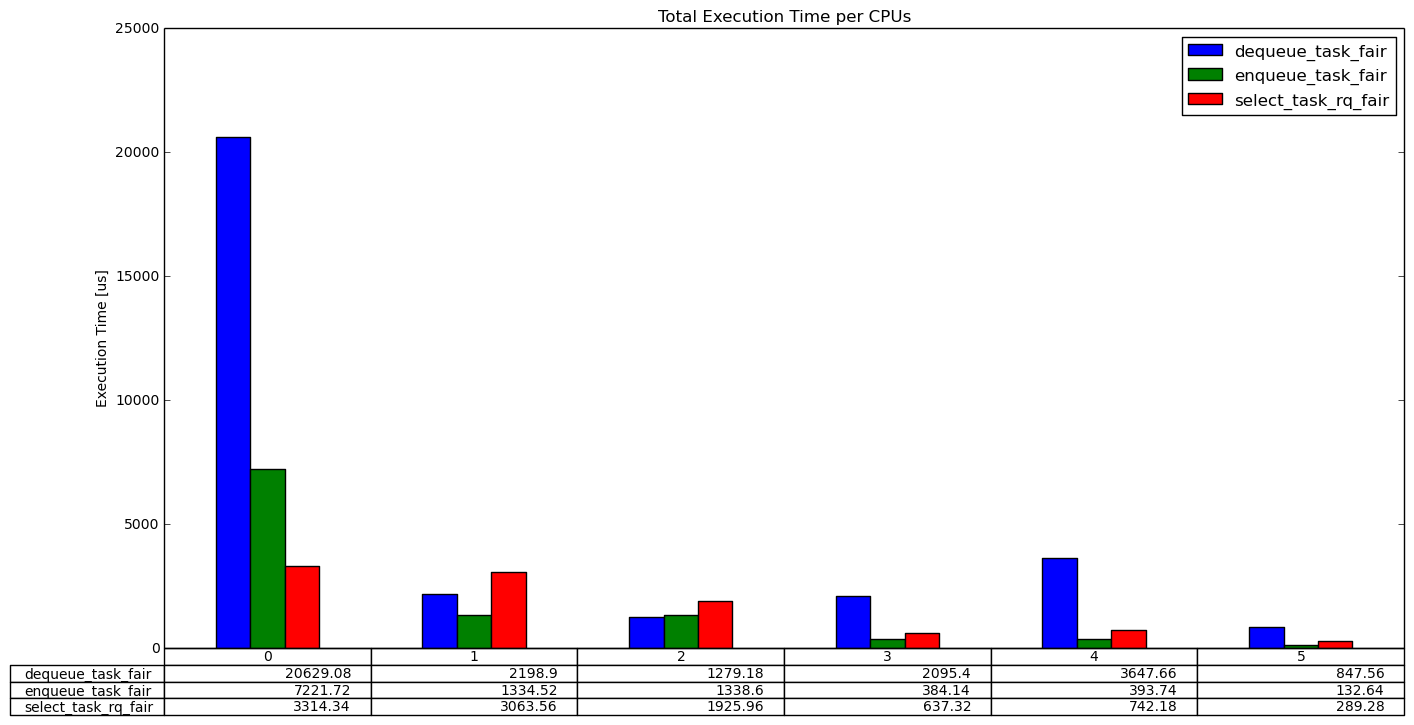

In [12]:
# Plot Average and Total execution time for the specified
# list of kernel functions
trace.analysis.functions.plotProfilingStats(
    functions = [
        'select_task_rq_fair',
        'enqueue_task_fair',
        'dequeue_task_fair'
    ],
    metrics = [
        # Average completion time per CPU
        'avg',
        # Total execution time per CPU
        'time',
    ]
)

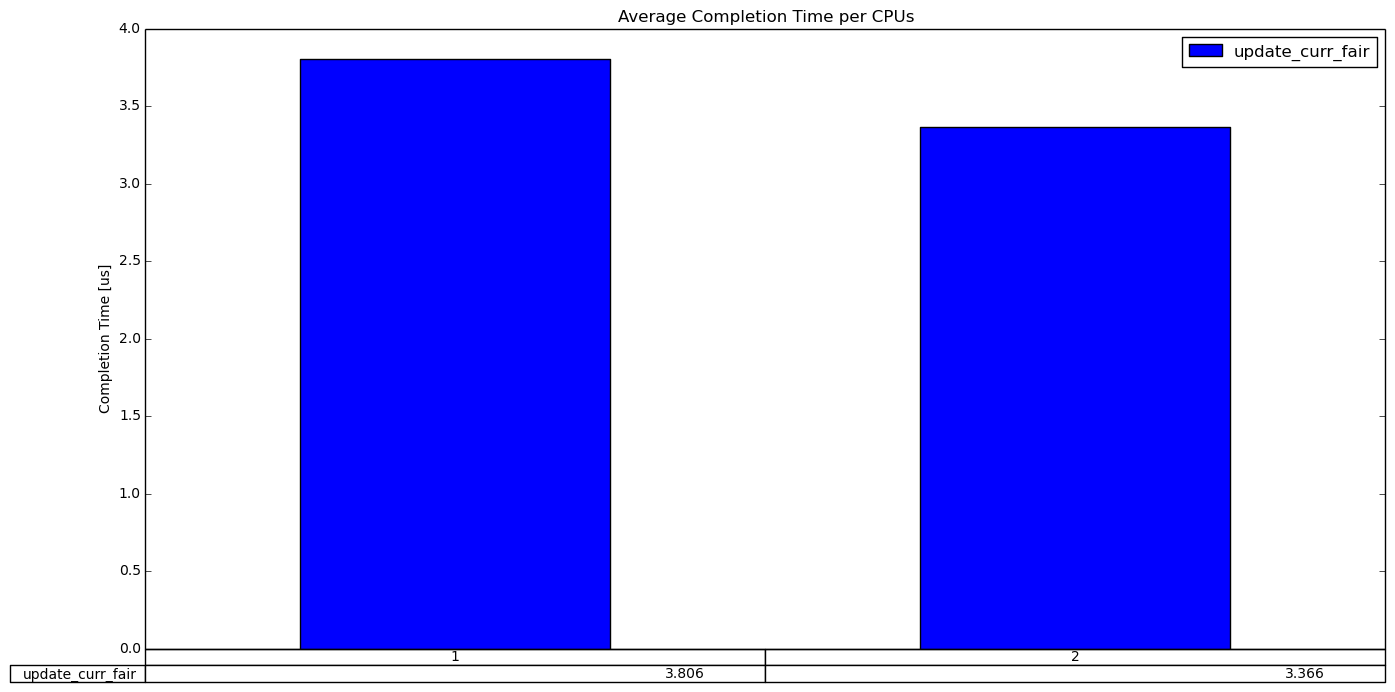

In [13]:
# Plot Average execution time for the single specified kernel function
trace.analysis.functions.plotProfilingStats(
    functions = 'update_curr_fair',
)